In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import os
import sys
import pathlib
import pickle
import warnings

sys.path.append('..')

In [4]:
import pandas as pd
from loguru import logger
import seaborn as sns

In [5]:
from pals.pimp_tools import get_pimp_API_token_from_env, PIMP_HOST, download_from_pimp
from pals.noise import construct_intensity_df, add_random_peaks, plot_intensity_matrix, convert_to_data_source
from pals.feature_extraction import DataSource
from pals.pathway_analysis import PALS
from pals.common import *

2019-12-19 22:32:17.043 | WARNING  | pals.reactome:get_neo4j_driver:14 - Using a default neo4j server: bolt://localhost:7687
2019-12-19 22:32:17.044 | WARNING  | pals.reactome:get_neo4j_driver:19 - Using a default neo4j username or password: neo4j
2019-12-19 22:32:18.111 | INFO     | pals.reactome:get_neo4j_driver:24 - Created graph database driver for bolt://localhost:7687 (neo4j)


## Heat map of intensity matrix

In [6]:
control_fnames = ['Control_1.mzXML', 'Control_2.mzXML', 'Control_3.mzXML', 'Control_4.mzXML']
case_fnames = ['Case_1.mzXML', 'Case_2.mzXML', 'Case_3.mzXML', 'Case_4.mzXML']
sample_fnames = control_fnames + case_fnames

pathway_names ={'two':2, 'four':4, 'six':6, 'ten':10, 'twenty':20, 'forty':40, 'eighty':80}

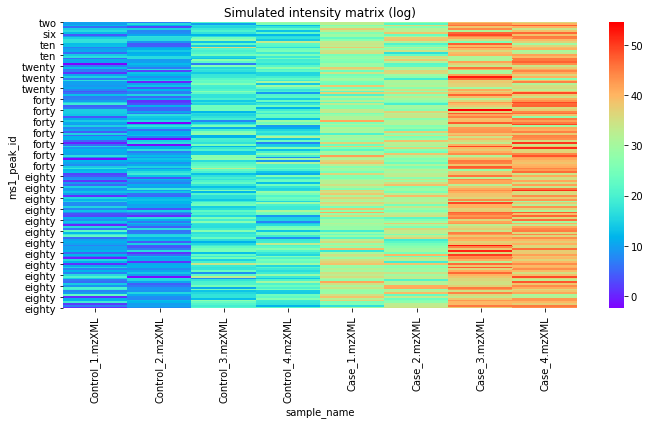

In [7]:
int_df = construct_intensity_df(sample_fnames, pathway_names, random=False)
plot_intensity_matrix(int_df)

In [8]:
# percent = 50
# noise_mean = 0
# noise_std = 5
# int_df = add_random_peaks(sample_fnames, pathway_names, int_df, percent, noise_mean, noise_std)
# plot_intensity_matrix(int_df)

Convert simulated data above to a PALS DataSource object and run pathway analysis

In [9]:
ds = convert_to_data_source(int_df, pathway_names, case_fnames, control_fnames)
pals = PALS(ds, min_replace=5000, plage_weight=1, hg_weight=1)

2019-12-19 22:33:23.826 | DEBUG    | pals.feature_extraction:__init__:43 - Using user-provided database
2019-12-19 22:33:23.827 | DEBUG    | pals.feature_extraction:__init__:51 - Mapping pathway to unique ids
2019-12-19 22:33:23.828 | DEBUG    | pals.feature_extraction:__init__:65 - Creating dataset to pathway mapping
2019-12-19 22:33:23.840 | DEBUG    | pals.feature_extraction:__init__:93 - Computing unique id counts


In [10]:
pals_df = pals.get_pathway_df()

2019-12-19 22:33:25.056 | DEBUG    | pals.pathway_analysis:_change_zero_peak_ints:395 - Setting the zero intensity values in the dataframe
2019-12-19 22:33:25.072 | DEBUG    | pals.pathway_analysis:_standardize_intensity_df:376 - Scaling the data across the sample: zero mean and unit variance
2019-12-19 22:33:25.075 | DEBUG    | pals.pathway_analysis:get_plage_activity_df:208 - Mean values of the rows in the DF is [ 0.  0.  0.  0.  0.  0.  0. -0.  0. -0.  0.  0. -0.  0. -0. -0.  0.  0.
  0. -0.  0. -0. -0.  0. -0.  0. -0. -0.  0. -0. -0. -0. -0.  0.  0.  0.
  0.  0.  0.  0. -0. -0. -0. -0.  0.  0.  0. -0. -0. -0.  0.  0.  0. -0.
  0.  0.  0.  0.  0. -0.  0. -0.  0.  0. -0.  0. -0. -0.  0. -0. -0.  0.
  0.  0.  0.  0.  0. -0.  0.  0.  0. -0. -0. -0.  0. -0. -0.  0.  0. -0.
  0.  0.  0. -0. -0. -0.  0.  0. -0. -0.  0. -0. -0. -0.  0.  0.  0. -0.
 -0.  0. -0.  0. -0.  0.  0.  0. -0.  0.  0.  0. -0.  0.  0. -0.  0. -0.
  0. -0.  0.  0.  0.  0. -0. -0.  0. -0. -0. -0. -0. -0. -0.  0.  0.  0

In [11]:
ora_df = pals.get_ora_df()

2019-12-19 22:33:26.212 | DEBUG    | pals.pathway_analysis:get_ora_df:50 - Calculating ORA
2019-12-19 22:33:26.213 | DEBUG    | pals.pathway_analysis:_change_zero_peak_ints:395 - Setting the zero intensity values in the dataframe
2019-12-19 22:33:26.228 | DEBUG    | pals.pathway_analysis:get_ora_df:92 - pw=forty comp=case/control M=162 n=150 N=40 k=38 sf=0.393055
2019-12-19 22:33:26.232 | DEBUG    | pals.pathway_analysis:get_ora_df:92 - pw=two comp=case/control M=162 n=150 N=2 k=2 sf=0.856913
2019-12-19 22:33:26.235 | DEBUG    | pals.pathway_analysis:get_ora_df:92 - pw=ten comp=case/control M=162 n=150 N=10 k=9 sf=0.837764
2019-12-19 22:33:26.237 | DEBUG    | pals.pathway_analysis:get_ora_df:92 - pw=twenty comp=case/control M=162 n=150 N=20 k=18 sf=0.829301
2019-12-19 22:33:26.240 | DEBUG    | pals.pathway_analysis:get_ora_df:92 - pw=four comp=case/control M=162 n=150 N=4 k=4 sf=0.732822
2019-12-19 22:33:26.243 | DEBUG    | pals.pathway_analysis:get_ora_df:92 - pw=eighty comp=case/cont

### Check EA-scores as we add more noisy peaks

In [12]:
def calc_av_p_scores(sample_fnames, pathway_names, num_iterations, percent=None, random=False, noise_mean=0, noise_std=5):
    results = {
        'pals': [],
        'ora': []
    }
    
    set_log_level_info()
    for it in range(num_iterations):
        logger.info('Iteration %d' % it)
        # constructs the peak intensity dataframe, adding random peaks if necessary
        int_df = construct_intensity_df(sample_fnames, pathway_names, random=random)        
        if percent is not None: # have random peaks
            int_df = add_random_peaks(sample_fnames, pathway_names, int_df, percent, noise_mean, noise_std)
            
        ds = convert_to_data_source(int_df, pathway_names, case_fnames, control_fnames)        
        pals = PALS(ds, min_replace=5000, plage_weight=1, hg_weight=1)
        pathway_df = pals.get_pathway_df()
        ora_df = pals.get_ora_df()
        
        results['pals'].append(pathway_df)
        results['ora'].append(ora_df)

    set_log_level_debug()
    return results

In [13]:
def construct_single_box_df(results, random_peaks, method):
    df = pd.concat(results[method], axis=0)
    columns = ['Pathway', 'Random_peaks', 'p_value', 'comb_p_value', 'method']
    box_plot_df = pd.DataFrame(columns=columns)
    box_plot_df['Pathway'] = list(df.index)
    box_plot_df['Random_peaks'] = float(random_peaks)
    box_plot_df['p_value'] = df['case/control p-value'].values
    box_plot_df['comb_p_value'] = df['case/control comb_p'].values
    box_plot_df['method'] = method
    return box_plot_df

In [14]:
NUM_ITERATIONS = 100
random = False # whether to sample intensity data randomly or using pre-set values

reqd_scenarios = [
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': 5, 'percent': 0 },
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': 5, 'percent': 50 },
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': 5, 'percent': 100 },
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': 5, 'percent': 200 },
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': 5, 'percent': 300 },
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': 5, 'percent': 1000 },
]

In [15]:
pals_dfs = []
ora_dfs = []
for i in range(len(reqd_scenarios)):
    scenario = reqd_scenarios[i]
    logger.info(scenario)
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', r'divide by zero')
        results = calc_av_p_scores(sample_fnames, pathway_names, NUM_ITERATIONS, 
                              percent=scenario['percent'], random=scenario['random'], noise_std=scenario['noise_std'])
    df = construct_single_box_df(results, scenario['percent'], 'pals')        
    pals_dfs.append(df)
    df = construct_single_box_df(results, scenario['percent'], 'ora')        
    ora_dfs.append(df)   

pals_df = pd.concat(pals_dfs, axis=0)
ora_df = pd.concat(ora_dfs, axis=0)

2019-12-19 22:33:38.525 | INFO     | __main__:<module>:5 - {'num_iterations': 100, 'random': False, 'noise_std': 5, 'percent': 0}
2019-12-19 22:33:38.526 | INFO     | __main__:calc_av_p_scores:9 - Iteration 0
2019-12-19 22:33:39.581 | INFO     | __main__:calc_av_p_scores:9 - Iteration 1
2019-12-19 22:33:40.661 | INFO     | __main__:calc_av_p_scores:9 - Iteration 2
2019-12-19 22:33:41.726 | INFO     | __main__:calc_av_p_scores:9 - Iteration 3
2019-12-19 22:33:42.818 | INFO     | __main__:calc_av_p_scores:9 - Iteration 4
2019-12-19 22:33:43.874 | INFO     | __main__:calc_av_p_scores:9 - Iteration 5
2019-12-19 22:33:44.931 | INFO     | __main__:calc_av_p_scores:9 - Iteration 6
2019-12-19 22:33:45.972 | INFO     | __main__:calc_av_p_scores:9 - Iteration 7
2019-12-19 22:33:47.070 | INFO     | __main__:calc_av_p_scores:9 - Iteration 8
2019-12-19 22:33:48.140 | INFO     | __main__:calc_av_p_scores:9 - Iteration 9
2019-12-19 22:33:49.220 | INFO     | __main__:calc_av_p_scores:9 - Iteration 10


In [16]:
pals_df

,Pathway,Random_peaks,p_value,comb_p_value,method
0,forty,0.0,0.027143,1.0,pals
1,two,0.0,0.078289,1.0,pals
2,ten,0.0,0.026455,1.0,pals
3,twenty,0.0,0.022026,1.0,pals
4,four,0.0,0.037640,1.0,pals
...,...,...,...,...,...
695,ten,1000.0,0.118780,1.0,pals
696,twenty,1000.0,0.028856,1.0,pals
697,four,1000.0,0.051242,1.0,pals
698,eighty,1000.0,0.015332,1.0,pals


In [17]:
ora_df

,Pathway,Random_peaks,p_value,comb_p_value,method
0,forty,0.0,0.829522,0.967776,ora
1,two,0.0,0.990798,0.990798,ora
2,ten,0.0,0.342441,0.967776,ora
3,twenty,0.0,0.382133,0.967776,ora
4,four,0.0,0.656994,0.967776,ora
...,...,...,...,...,...
695,ten,1000.0,0.820552,0.844577,ora
696,twenty,1000.0,0.170433,0.844577,ora
697,four,1000.0,0.464953,0.844577,ora
698,eighty,1000.0,0.242048,0.844577,ora


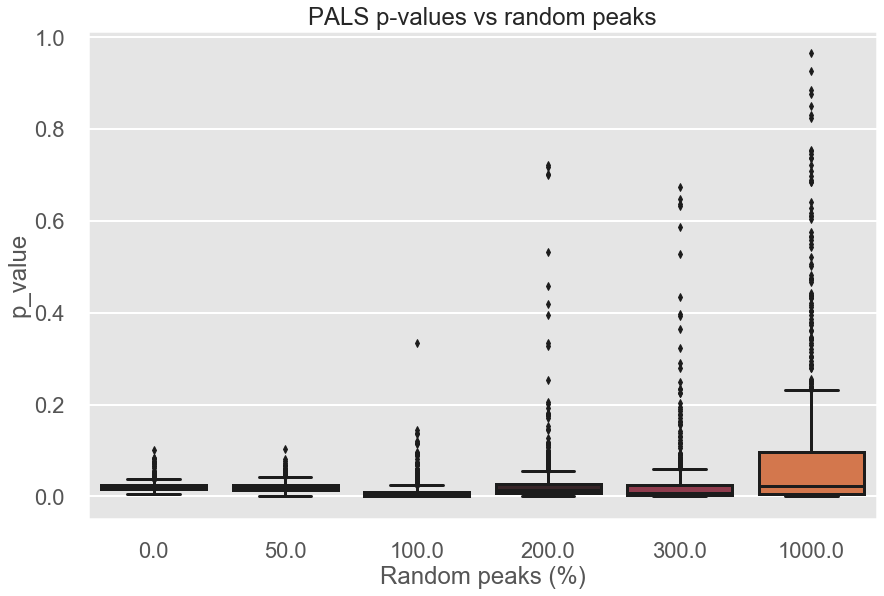

In [18]:
style.use('seaborn-poster') #sets the size of the charts
sns.set(style="whitegrid")
style.use('ggplot')
sns.set_context('poster')  #Everything is larger

ax = sns.boxplot(x="Random_peaks", y="p_value", data=pals_df, palette=("icefire"))
# ax = sns.swarmplot(x="Random_peaks", y="p_value", hue="Pathway", data=box_plot_df, size=10, palette=("YlGnBu"))
ax.set(xlabel='Random peaks (%)', ylabel='p_value')
plt.title("PALS p-values vs random peaks")
plt.tight_layout()
# plt.savefig("box_plot.eps", dpi=300)

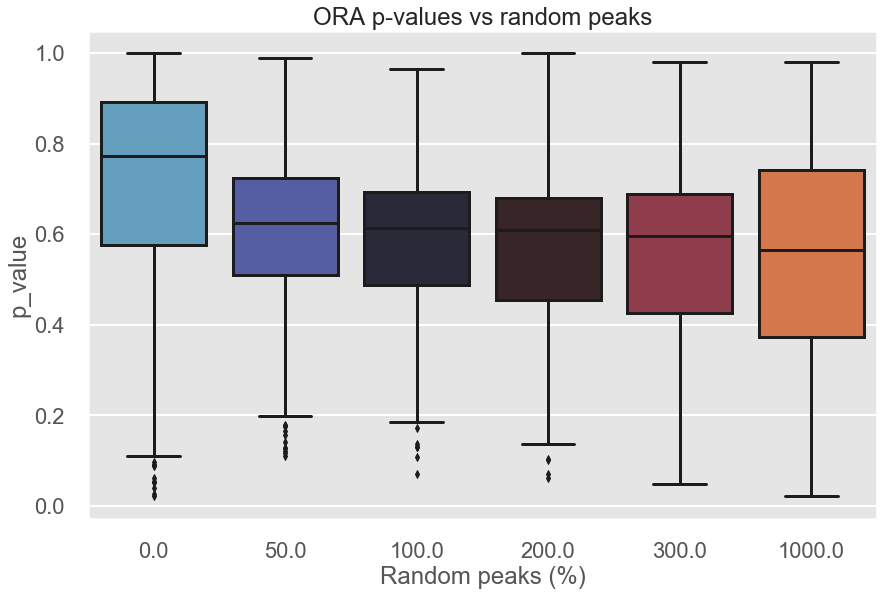

In [19]:
style.use('seaborn-poster') #sets the size of the charts
sns.set(style="whitegrid")
style.use('ggplot')
sns.set_context('poster')  #Everything is larger

ax = sns.boxplot(x="Random_peaks", y="p_value", data=ora_df, palette=("icefire"))
# ax = sns.swarmplot(x="Random_peaks", y="p_value", hue="Pathway", data=box_plot_df, size=10, palette=("YlGnBu"))
ax.set(xlabel='Random peaks (%)', ylabel='p_value')
plt.title("ORA p-values vs random peaks")
plt.tight_layout()
# plt.savefig("box_plot.eps", dpi=300)

### Plot EA score changes as we add more random peaks at varying noise level

In [22]:
def get_combined_df(percents, noise_std, num_iterations):
    pals_dfs = []
    ora_dfs = []
    for percent in percents:
        logger.info('percent=%.2f noise_std=%.1f' % (percent, noise_std))
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore', r'divide by zero')
            results = calc_av_p_scores(sample_fnames, pathway_names, num_iterations=num_iterations, percent=percent, noise_std=noise_std)
        df = construct_single_box_df(results, percent, 'pals')        
        pals_dfs.append(df)
        df = construct_single_box_df(results, percent, 'ora')        
        ora_dfs.append(df)   

    pals_df = pd.concat(pals_dfs, axis=0)
    ora_df = pd.concat(ora_dfs, axis=0)
    return pals_df, ora_df

#### Noise std deviation = 5

In [23]:
percents = [0, 50, 100, 200, 300, 1000]
noise_std = 5
pals_df, ora_df = get_combined_df(percents, noise_std, NUM_ITERATIONS)

2019-12-19 22:52:10.882 | INFO     | __main__:get_combined_df:5 - percent=0.00 noise_std=5.0
2019-12-19 22:52:10.883 | INFO     | __main__:calc_av_p_scores:9 - Iteration 0
2019-12-19 22:52:11.997 | INFO     | __main__:calc_av_p_scores:9 - Iteration 1
2019-12-19 22:52:13.050 | INFO     | __main__:calc_av_p_scores:9 - Iteration 2
2019-12-19 22:52:14.149 | INFO     | __main__:calc_av_p_scores:9 - Iteration 3
2019-12-19 22:52:15.268 | INFO     | __main__:calc_av_p_scores:9 - Iteration 4
2019-12-19 22:52:16.381 | INFO     | __main__:calc_av_p_scores:9 - Iteration 5
2019-12-19 22:52:17.489 | INFO     | __main__:calc_av_p_scores:9 - Iteration 6
2019-12-19 22:52:18.579 | INFO     | __main__:calc_av_p_scores:9 - Iteration 7
2019-12-19 22:52:19.737 | INFO     | __main__:calc_av_p_scores:9 - Iteration 8
2019-12-19 22:52:20.900 | INFO     | __main__:calc_av_p_scores:9 - Iteration 9
2019-12-19 22:52:22.045 | INFO     | __main__:calc_av_p_scores:9 - Iteration 10
2019-12-19 22:52:23.137 | INFO     | 

In [24]:
pals_df['Pathway'] = pd.Categorical(pals_df['Pathway'], ['eighty', 'forty', 'twenty', 'ten', 'six', 'four', 'two'])
ora_df['Pathway'] = pd.Categorical(ora_df['Pathway'], ['eighty', 'forty', 'twenty', 'ten', 'six', 'four', 'two'])

pals_df = pals_df.sort_values('Pathway')
ora_df = ora_df.sort_values('Pathway')

Text(0.5, 1.0, 'The effect of adding random peaks to PALS EA score (noise_std=5)')

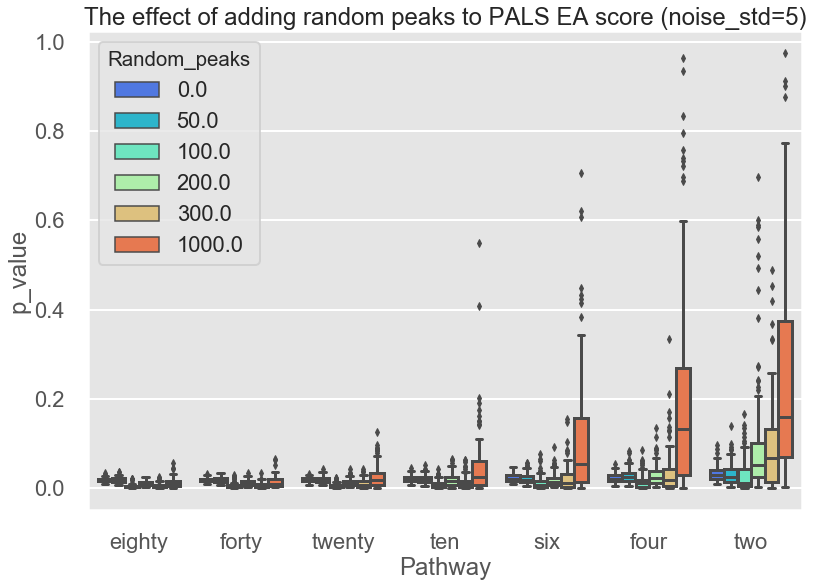

In [25]:
sns.boxplot(x='Pathway', y='p_value', hue='Random_peaks', data=pals_df, palette=("rainbow"))
plt.title('The effect of adding random peaks to PALS EA score (noise_std=%d)' % noise_std)

Text(0.5, 1.0, 'The effect of adding random peaks to ORA p_value (noise_std=5)')

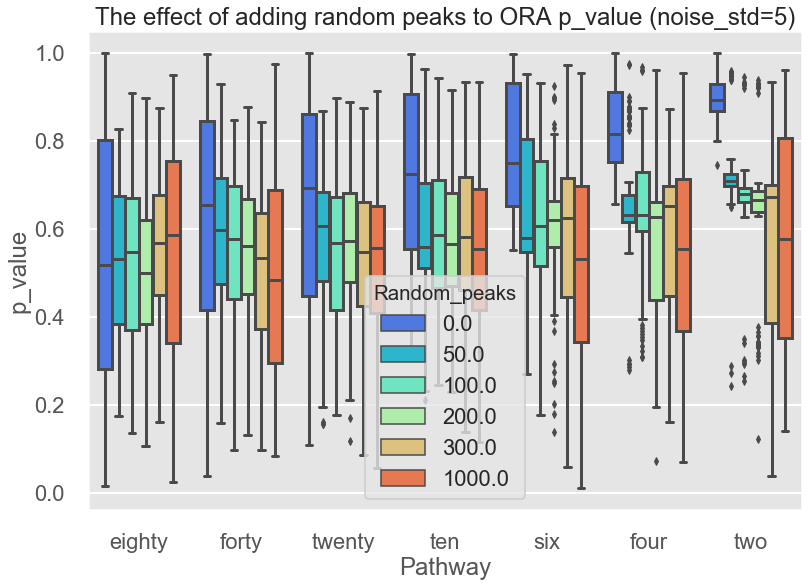

In [26]:
sns.boxplot(x='Pathway', y='p_value', hue='Random_peaks', data=ora_df, palette=("rainbow"))
plt.title('The effect of adding random peaks to ORA p_value (noise_std=%d)' % noise_std)

#### Noise std deviation = 1

In [27]:
percents = [0, 50, 100, 200, 300, 1000]
noise_std = 1
pals_df, ora_df = get_combined_df(percents, noise_std, NUM_ITERATIONS)

2019-12-19 23:03:52.228 | INFO     | __main__:get_combined_df:5 - percent=0.00 noise_std=1.0
2019-12-19 23:03:52.230 | INFO     | __main__:calc_av_p_scores:9 - Iteration 0
2019-12-19 23:03:53.302 | INFO     | __main__:calc_av_p_scores:9 - Iteration 1
2019-12-19 23:03:54.472 | INFO     | __main__:calc_av_p_scores:9 - Iteration 2
2019-12-19 23:03:55.605 | INFO     | __main__:calc_av_p_scores:9 - Iteration 3
2019-12-19 23:03:56.697 | INFO     | __main__:calc_av_p_scores:9 - Iteration 4
2019-12-19 23:03:57.775 | INFO     | __main__:calc_av_p_scores:9 - Iteration 5
2019-12-19 23:03:58.989 | INFO     | __main__:calc_av_p_scores:9 - Iteration 6
2019-12-19 23:04:00.200 | INFO     | __main__:calc_av_p_scores:9 - Iteration 7
2019-12-19 23:04:01.303 | INFO     | __main__:calc_av_p_scores:9 - Iteration 8
2019-12-19 23:04:02.401 | INFO     | __main__:calc_av_p_scores:9 - Iteration 9
2019-12-19 23:04:03.464 | INFO     | __main__:calc_av_p_scores:9 - Iteration 10
2019-12-19 23:04:04.554 | INFO     | 

In [28]:
pals_df['Pathway'] = pd.Categorical(pals_df['Pathway'], ['eighty', 'forty', 'twenty', 'ten', 'six', 'four', 'two'])
ora_df['Pathway'] = pd.Categorical(ora_df['Pathway'], ['eighty', 'forty', 'twenty', 'ten', 'six', 'four', 'two'])

pals_df = pals_df.sort_values('Pathway')
ora_df = ora_df.sort_values('Pathway')

Text(0.5, 1.0, 'The effect of adding random peaks to PALS EA score (noise_std=1)')

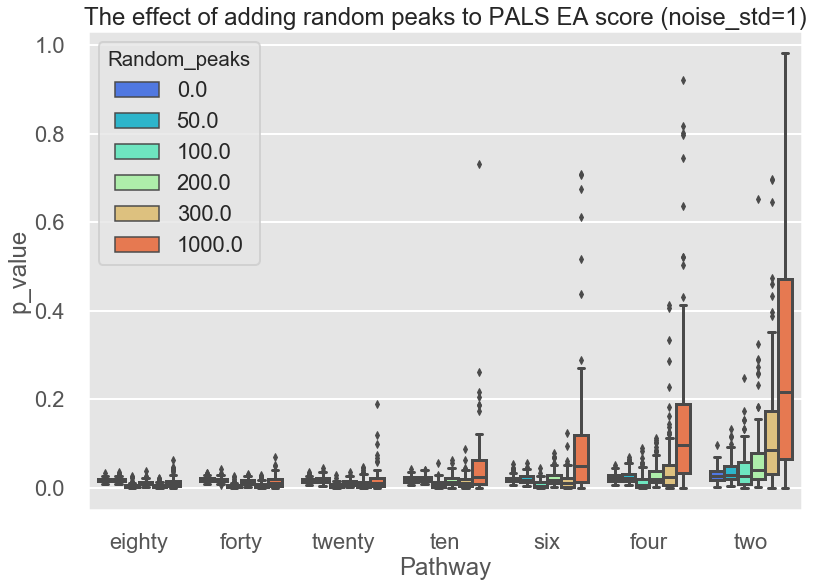

In [29]:
sns.boxplot(x='Pathway', y='p_value', hue='Random_peaks', data=pals_df, palette=("rainbow"))
plt.title('The effect of adding random peaks to PALS EA score (noise_std=%d)' % noise_std)

Text(0.5, 1.0, 'The effect of adding random peaks to ORA p_value (noise_std=1)')

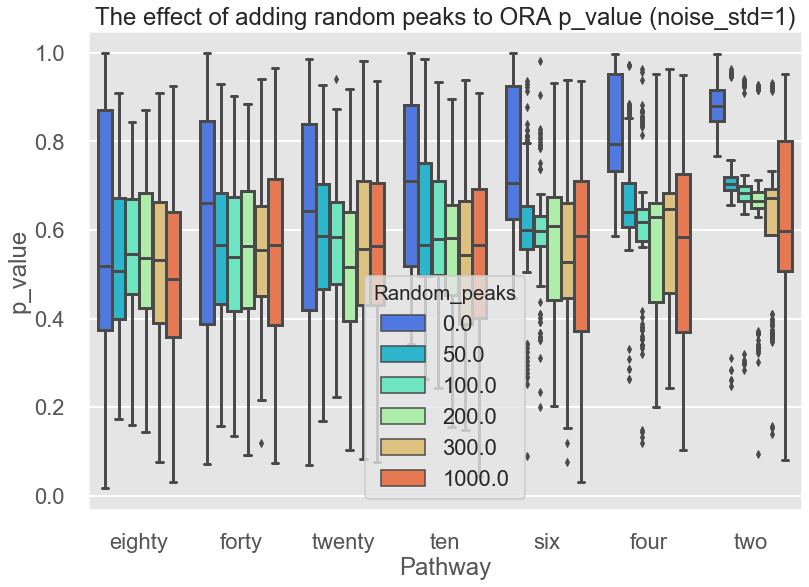

In [30]:
sns.boxplot(x='Pathway', y='p_value', hue='Random_peaks', data=ora_df, palette=("rainbow"))
plt.title('The effect of adding random peaks to ORA p_value (noise_std=%d)' % noise_std)

#### Nothing is changing, it's all random

In [31]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', r'divide by zero')
    results = calc_av_p_scores(sample_fnames, pathway_names, num_iterations=1, random=True)
    pals_df = construct_single_box_df(results, scenario['percent'], 'pals')        
    ora_df = construct_single_box_df(results, scenario['percent'], 'ora')        

2019-12-19 23:15:58.820 | INFO     | __main__:calc_av_p_scores:9 - Iteration 0


In [32]:
pals_df

,Pathway,Random_peaks,p_value,comb_p_value,method
0,forty,1000.0,0.936050,1.0,pals
1,two,1000.0,0.997881,1.0,pals
2,ten,1000.0,0.958153,1.0,pals
3,twenty,1000.0,0.911786,1.0,pals
4,four,1000.0,0.985595,1.0,pals
5,eighty,1000.0,0.367336,1.0,pals
6,six,1000.0,0.781336,1.0,pals


In [33]:
ora_df

,Pathway,Random_peaks,p_value,comb_p_value,method
0,forty,1000.0,0.667554,1.0,ora
1,two,1000.0,1.000000,1.0,ora
2,ten,1000.0,0.577587,1.0,ora
3,twenty,1000.0,0.832169,1.0,ora
4,four,1000.0,1.000000,1.0,ora
5,eighty,1000.0,0.481190,1.0,ora
6,six,1000.0,0.399609,1.0,ora
